In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import statsmodels 
import statsmodels.formula.api as smf
from statistics import NormalDist
from matplotlib.backends.backend_pdf import PdfPages


In [2]:
data1=pd.read_excel ("/Users/matteoanzano/Desktop/Python/Alessia Conti/EUROPA.xls")

In [3]:
data2=pd.read_excel("/Users/matteoanzano/Desktop/Python/Alessia Conti/STATI UNITI.xls")

In [4]:
data=data1 #creo un altro dataset, per non intaccare il principale
data.index = pd.DatetimeIndex(data.DATA) #imposto la colonna data come indice per poter lavorare con pandas 
data=data.drop("DATA", axis=1) #rimuovo la colonna date perchè ora è impostata come indice axis=1, sto lavorando con le colonne 
data.columns #stampo le colonne 

Index(['ATTIVITÀ_BANCHE', 'ATTIVITÀ_FONDI', 'PIL_REALE', 'DEFLATORE_PIL',
       'TASSO_OIS_A_1_ANNO', 'SPREAD_OBBLIGAZIONI', 'TASSO_DI_INT_BANCARIO',
       'SPREAD_PRESTITO', 'SHORT_SHOCKS', 'LONG_SHOCKS',
       'SHORT_SHOCKS_CORRECTED', 'LONG_SHOCKS_CORRECTED', 'short_new',
       'long_new', 'short_corrected', 'long_corrected'],
      dtype='object')

In [5]:
Data=data2 #creo un altro dataset, per non intaccare il principale
Data.index = pd.DatetimeIndex(Data.DATA) #imposto la colonna data come indice per poter lavorare con pandas 
Data=Data.drop("DATA", axis=1) #rimuovo la colonna date perchè ora è impostata come indice axis=1, sto lavorando con le colonne 
Data.columns #stampo le colonne 

Index(['ATTIVITÀ_BANCHE', 'ATTIVITÀ_FONDI', 'PIL_REALE', 'DEFLATORE_PIL',
       'TASSO_OIS_A_1_ANNO', 'SPREAD_OBBLIGAZIONI', 'TASSO_DI_INT_BANCARIO',
       'SPREAD_PRESTITO', 'SHORT_SHOCKS', 'LONG_SHOCKS',
       'SHORT_SHOCKS_CORRECTED', 'LONG_SHOCKS_CORRECTED'],
      dtype='object')

In [6]:
data['ATTIVITÀ_BANCHE']=np.log(data['ATTIVITÀ_BANCHE'])
data['ATTIVITÀ_FONDI']=np.log(data['ATTIVITÀ_FONDI'])
data['PIL_REALE']=np.log(data['PIL_REALE'])
dataset=data[['ATTIVITÀ_BANCHE','ATTIVITÀ_FONDI','PIL_REALE','DEFLATORE_PIL','TASSO_OIS_A_1_ANNO',
'SPREAD_OBBLIGAZIONI','SPREAD_PRESTITO','SHORT_SHOCKS_CORRECTED','LONG_SHOCKS_CORRECTED', 'short_new', 'long_new', 'short_corrected', 'long_corrected']] #creo un nuovo dataset ordinando le colonne come mi interessa

In [7]:
dataset.head()

,ATTIVITÀ_BANCHE,ATTIVITÀ_FONDI,PIL_REALE,DEFLATORE_PIL,TASSO_OIS_A_1_ANNO,SPREAD_OBBLIGAZIONI,SPREAD_PRESTITO,SHORT_SHOCKS_CORRECTED,LONG_SHOCKS_CORRECTED,short_new,long_new,short_corrected,long_corrected
DATA,,,,,,,,,,,,,
1999-01-01,15.893254,NaN,14.517026,76.20,3.0537,NaN,-3.0537,0.00,0.57,0.0,2.85,0.0,2.85
1999-04-01,15.881888,NaN,14.521534,76.68,2.6086,NaN,-2.6086,-0.08,0.86,-0.5,5.15,0.0,5.15
1999-07-01,15.933944,NaN,14.532845,76.90,2.4658,1.013109,-2.4658,-1.00,0.00,-6.0,0.00,-6.0,0.00
1999-10-01,15.906166,NaN,14.544294,77.85,2.8314,0.939431,-2.8314,0.00,-1.13,0.0,-6.75,-7.0,-6.75
2000-01-01,15.868788,NaN,14.556623,77.04,3.2835,0.869726,3.2565,-1.14,-1.29,-8.0,-9.05,-8.0,-9.05


In [8]:
Data['ATTIVITÀ_BANCHE']=np.log(Data['ATTIVITÀ_BANCHE'])
Data['ATTIVITÀ_FONDI']=np.log(Data['ATTIVITÀ_FONDI'])
Data['PIL_REALE']=np.log(Data['PIL_REALE'])
Dataset=Data[['ATTIVITÀ_BANCHE','ATTIVITÀ_FONDI','PIL_REALE','DEFLATORE_PIL','TASSO_OIS_A_1_ANNO',
'SPREAD_OBBLIGAZIONI','SPREAD_PRESTITO','SHORT_SHOCKS_CORRECTED','LONG_SHOCKS_CORRECTED']] #creo un nuovo dataset ordinando le colonne come mi interessa

# IRFS


In [9]:
def TimeSeriesLP(data, Y, response, shock,horizon, lags, newey_lags=4, ci_width=0.95):
    ## Illegal inputs
    if (ci_width >= 1) | (ci_width <= 0): raise NotImplementedError('CI Width must be within (0, 1), non-inclusive!')
    if horizon < 1: raise NotImplementedError('Estimation horizon for IRFs must be at least 1')
    if lags < 1: raise NotImplementedError('Number of lags in the model must be at least 1')
    ## Preliminaries
    col_output = ['Shock', 'Response', 'Horizon', 'Mean', 'LB', 'UB'] # Column names of the output dataframe
    irf_full = pd.DataFrame(columns=col_output) # Empty output dataframe to be filled over every iteration
    z_val = NormalDist().inv_cdf((1 + ci_width) / 2) # Determines what multiplier to use when calculating UB & LB from SE
    for r in response:
        ## Check ordering of response variable in the full list of Y
        s_loc = Y.index(shock)
    ## Generate copy of data for horizon h + first difference RHS variables + transform response variable to desired horizon
        for h in range(horizon+1):
            d = data.copy()
            d[r+'forward'] = d[r].shift(-h) # forward; equivalent to F`h'. in Stata
            ## Generate lags of RHS variables (only the first, either l0 or l1 will be used in the IRFs)
            list_RHS_forReg = []
            for y in Y:   # This model does not manage ownshocks
                if Y.index(y) != s_loc: # include lagged response variables on the RHS
                    for l in range(1, lags+1):
                        d[y + str(l) + 'lag'] = d[y].shift(l) # for lagged dependent variable, we will use _l1 to generate the IRF
                        list_RHS_forReg = list_RHS_forReg + [y + str(l) + 'lag']
                if Y.index(y) == s_loc: # include lagged response variables on the RHS
                    list_RHS_forReg=list_RHS_forReg+[y]
                    for l in range(1, lags+1):
                        d[y + str(l) + 'lag'] = d[y].shift(l) # for lagged dependent variable, we will use _l1 to generate the IRF
                        list_RHS_forReg = list_RHS_forReg + [y + str(l) + 'lag']
            d = d.dropna(axis=0) # clear all rows with NAs from the lag / forward transformation
            eqn = r+'forward' + '~' + '+'.join(list_RHS_forReg)
            mod = smf.ols(eqn, data=d)
            est = mod.fit(cov_type='HAC',cov_kwds={'maxlags':newey_lags})
            beta = est.params
            se = est.bse
            z=shock
            irf = pd.DataFrame([[1] * len(col_output)], columns=col_output) # double list = single row
            irf['Response'] = r
            irf['Horizon'] = h
            irf['Shock'] = z
            irf['Mean'] = beta[z]
            irf['LB'] = beta[z] - z_val * se[z]
            irf['UB'] = beta[z] + z_val * se[z]
            irf_full = pd.concat([irf_full, irf], axis=0) # top to bottom concat
    ## Sort by response, shock, horizon
    irf_full = irf_full.sort_values(by=['Response', 'Shock', 'Horizon'], axis=0, ascending=[True, True, True])
    return irf_full

    

In [12]:
endog = ['ATTIVITÀ_BANCHE','LONG_SHOCKS_CORRECTED', 'DEFLATORE_PIL','PIL_REALE','SPREAD_PRESTITO','SPREAD_OBBLIGAZIONI','TASSO_OIS_A_1_ANNO', 'ATTIVITÀ_FONDI'] # definisco le variabili endogene
response = ['ATTIVITÀ_BANCHE'] #definisco le variabili di risposta
shock='LONG_SHOCKS_CORRECTED' #definisco lo shock

irf_horizon = 8 # stima le IRF 8 periodi in avanti
opt_lags = 6 #include 6 lags in the local projections model
opt_cov = 'robust'# utilizzo errori standard eteroschedastici, autocorrelati e coerenti 
opt_ci = 0.68 # imposto l'intervallo di confidenza al 68 per cento

# utilizzo la classe TimeSeriesLP for the single entity caseper stimare le IRF
irf_us = TimeSeriesLP(data=Dataset, # imposto il dataframe come imput
                      Y=endog, # il vettore della Y è impostato come le variabili endogene 
                      response=response,# imposto le variabili sulle quali definire le IRF
                      shock=shock,
                      horizon=irf_horizon, # imporsto l'orizzonte temporale delle IRF
                      lags=opt_lags, # numero di lags nel modello 
                      newey_lags=6, # massimo di lags nella stima degli errori newy-west
                      ci_width=opt_ci # imposto l'ampiezza dell'intevallo di confidenza
                      )

In [13]:
endog = ['ATTIVITÀ_BANCHE','long_corrected', 'DEFLATORE_PIL','PIL_REALE','SPREAD_PRESTITO','SPREAD_OBBLIGAZIONI','TASSO_OIS_A_1_ANNO', 'ATTIVITÀ_FONDI'] # definisco le variabili endogene
response = ['ATTIVITÀ_BANCHE'] #definisco le variabili di risposta
shock='long_corrected' #definisco lo shock

irf_horizon = 8 # stima le IRF 8 periodi in avanti
opt_lags = 6 #include 6 lags in the local projections model
opt_cov = 'robust'# utilizzo errori standard eteroschedastici, autocorrelati e coerenti 
opt_ci = 0.68 # imposto l'intervallo di confidenza al 68 per cento

# utilizzo la classe TimeSeriesLP for the single entity caseper stimare le IRF
irf_eu = TimeSeriesLP(data=dataset, # imposto il dataframe come imput
                      Y=endog, # il vettore della Y è impostato come le variabili endogene 
                      response=response,# imposto le variabili sulle quali definire le IRF
                      shock=shock,
                      horizon=irf_horizon, # imporsto l'orizzonte temporale delle IRF
                      lags=opt_lags, # numero di lags nel modello 
                      newey_lags=6, # massimo di lags nella stima degli errori newy-west
                      ci_width=opt_ci # imposto l'ampiezza dell'intevallo di confidenza
                      )

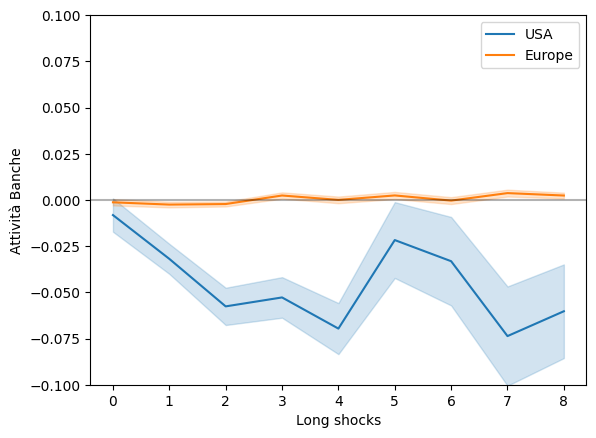

In [17]:
plt.plot(irf_us.Horizon,irf_us.Mean)
plt.plot(irf_eu.Horizon,irf_eu.Mean)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.fill_between(np.array(irf_us.Horizon ,dtype=float), irf_us.LB, irf_us.UB, alpha=0.2, color='tab:blue')
plt.fill_between(np.array(irf_eu.Horizon ,dtype=float), irf_eu.LB, irf_eu.UB, alpha=0.2, color='tab:orange')
#plt.fill_between(np.array(irf_us.Horizon ,dtype=float), irf_us1.LB, irf_us1.UB, alpha=0.1, color='tab:blue')
#plt.fill_between(np.array(irf_eu.Horizon ,dtype=float), irf_eu1.LB, irf_eu1.UB, alpha=0.1, color='tab:orange')
plt.ylim(-0.1,0.1)



plt.legend(['USA', 'Europe'])
plt.xlabel("Long shocks")
plt.ylabel("Attività Banche")
plt.show()


# Params

In [19]:
def TimeSeriesLPParams(data, Y, response, shock,irf_lag, lags, newey_lags=4, ci_width=0.95,p_values=True, round=3):
    ## Illegal inputs
    if (ci_width >= 1) | (ci_width <= 0): raise NotImplementedError('CI Width must be within (0, 1), non-inclusive!')
    if lags < 1: raise NotImplementedError('Number of lags in the model must be at least 1')
    ## Preliminaries
    col_output = ['Shock', 'Response', 'Horizon', 'Mean', 'LB', 'UB'] # Column names of the output dataframe
    for r in response:
        ## Check ordering of response variable in the full list of Y
        s_loc = Y.index(shock)
    ## Generate copy of data for horizon h + first difference RHS variables + transform response variable to desired horizon
        d = data.copy()
        d[r+'forward'] = d[r].shift(-irf_lag) # forward; equivalent to F`h'. in Stata
        ## Generate lags of RHS variables (only the first, either l0 or l1 will be used in the IRFs)
        list_RHS_forReg = []
        for y in Y:   # This model does not manage ownshocks
            if Y.index(y) != s_loc: # include lagged response variables on the RHS
                for l in range(1, lags+1):
                    d[y + str(l) + 'lag'] = d[y].shift(l) # for lagged dependent variable, we will use _l1 to generate the IRF
                    list_RHS_forReg = list_RHS_forReg + [y + str(l) + 'lag']
            if Y.index(y) == s_loc: # include lagged response variables on the RHS
                list_RHS_forReg=list_RHS_forReg+[y]
                for l in range(1, lags+1):
                    d[y + str(l) + 'lag'] = d[y].shift(l) # for lagged dependent variable, we will use _l1 to generate the IRF
                    list_RHS_forReg = list_RHS_forReg + [y + str(l) + 'lag']
        d = d.dropna(axis=0) # clear all rows with NAs from the lag / forward transformation
        eqn = r+'forward' + '~' + '+'.join(list_RHS_forReg)
        mod = smf.ols(eqn, data=d)
        est = mod.fit(cov_type='HAC',cov_kwds={'maxlags':newey_lags})
        beta = est.params
        beta_data=pd.DataFrame({str(irf_lag*3)+" months":beta}).round(round)
        if p_values==True:
            pvalue = est.pvalues
            pvalue_data=pd.DataFrame({str(irf_lag*3)+" months pvalues":pvalue}).round(round)
            beta_data=beta_data.join(pvalue_data)
    return beta_data

In [20]:
endog = ['ATTIVITÀ_BANCHE','SHORT_SHOCKS_CORRECTED', 'DEFLATORE_PIL','PIL_REALE','SPREAD_PRESTITO','SPREAD_OBBLIGAZIONI','TASSO_OIS_A_1_ANNO', 'ATTIVITÀ_FONDI'] # cholesky ordering: invest --> value --> capital
response = ['ATTIVITÀ_BANCHE']
shock='SHORT_SHOCKS_CORRECTED'
# estimate the responses of all variables to shocks from all variables
lag=2   # questa s è il lag che voglio avere nel modello alla y
opt_lags = 6 # include 6 lags in the local projections model
opt_cov = 'robust' # HAC standard errors
opt_ci = 0.68 # 95% confidence intervals

In [29]:
par = TimeSeriesLPParams(data=dataset, # input dataframe
                      Y=endog, # variables in the model
                      response=response, # variables whose IRFs should be estimated
                      shock=shock,
                      irf_lag=lag,
                      lags=opt_lags, # lags in the model
                      newey_lags=6, # maximum lags when estimating Newey-West standard errors
                      ci_width=opt_ci, # width of confidence band
                      p_values=True)

In [30]:
par

,6 months,6 months pvalues
Intercept,-13.406,0.177
ATTIVITÀ_BANCHE1lag,0.640,0.000
ATTIVITÀ_BANCHE2lag,-0.355,0.042
ATTIVITÀ_BANCHE3lag,-0.529,0.001
ATTIVITÀ_BANCHE4lag,0.357,0.006
ATTIVITÀ_BANCHE5lag,0.504,0.001
ATTIVITÀ_BANCHE6lag,-0.065,0.656
SHORT_SHOCKS_CORRECTED,0.001,0.765
SHORT_SHOCKS_CORRECTED1lag,0.009,0.171
SHORT_SHOCKS_CORRECTED2lag,-0.005,0.381


# Tabella

In [82]:
def TableParameters(data, Y, response, shock, irf_lags,lags, newey_lags=4, ci_width=0.95,p_values=True, round=3):
    for i in irf_lags:
        if i==irf_lags[0]:
            table = TimeSeriesLPParams(data=data, # input dataframe
                      Y=Y, # variables in the model
                      response=response, # variables whose IRFs should be estimated
                      shock=shock,
                      irf_lag=i,
                      lags=lags, # lags in the model
                      newey_lags=newey_lags, # maximum lags when estimating Newey-West standard errors
                      ci_width=opt_ci, # width of confidence band
                      p_values=p_values)
        if i!=irf_lags[0]:
            table1=TimeSeriesLPParams(data=data, # input dataframe
                      Y=Y, # variables in the model
                      response=response, # variables whose IRFs should be estimated
                      shock=shock,
                      irf_lag=i,
                      lags=lags, # lags in the model
                      newey_lags=newey_lags, # maximum lags when estimating Newey-West standard errors
                      ci_width=opt_ci, # width of confidence band
                      p_values=p_values)
            table=pd.merge(table,table1, left_index=True, right_index=True)
    return table

In [83]:
endog = ['ATTIVITÀ_BANCHE','SHORT_SHOCKS_CORRECTED', 'DEFLATORE_PIL','PIL_REALE','SPREAD_PRESTITO','SPREAD_OBBLIGAZIONI','TASSO_OIS_A_1_ANNO', 'ATTIVITÀ_FONDI'] # cholesky ordering: invest --> value --> capital
response = ['ATTIVITÀ_BANCHE']
shock='SHORT_SHOCKS_CORRECTED'
# estimate the responses of all variables to shocks from all variables
lags=[2,4,6,8]   # questa s è il lag che voglio avere nel modello alla y
opt_lags = 6 # include 6 lags in the local projections model
opt_cov = 'robust' # HAC standard errors
opt_ci = 0.68 # 95% confidence intervals

In [84]:
tabella = TableParameters(data=Dataset, # input dataframe
                      Y=endog, # variables in the model
                      response=response, # variables whose IRFs should be estimated
                      shock=shock,
                      irf_lags=lags,
                      lags=opt_lags, # lags in the model
                      newey_lags=6, # maximum lags when estimating Newey-West standard errors
                      ci_width=opt_ci, # width of confidence band
                      p_values=True)

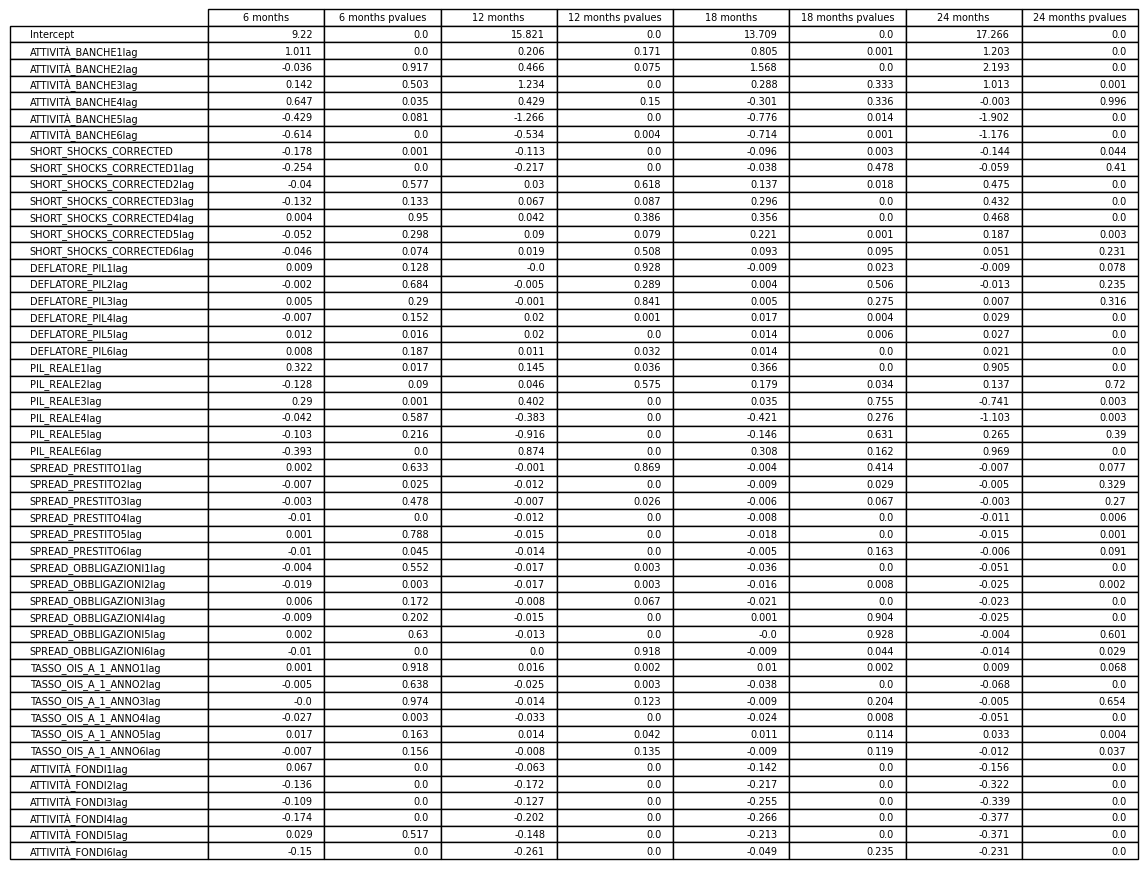

In [85]:
fig, ax =plt.subplots(figsize=(12,4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=tabella.values,colLabels=tabella.columns,loc='center', rowLabels=tabella.index)

In [86]:
pp = PdfPages("foo1.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()

In [11]:


dataset.head(2)

,ATTIVITÀ_BANCHE,ATTIVITÀ_FONDI,PIL_REALE,DEFLATORE_PIL,TASSO_OIS_A_1_ANNO,SPREAD_OBBLIGAZIONI,SPREAD_PRESTITO,SHORT_SHOCKS_CORRECTED,LONG_SHOCKS_CORRECTED,short_new,long_new,short_corrected,long_corrected
DATA,,,,,,,,,,,,,
1999-01-01,15.893254,NaN,14.517026,76.20,3.0537,NaN,-3.0537,0.00,0.57,0.0,2.85,0.0,2.85
1999-04-01,15.881888,NaN,14.521534,76.68,2.6086,NaN,-2.6086,-0.08,0.86,-0.5,5.15,0.0,5.15


In [12]:
Dataset.head(2)

,ATTIVITÀ_BANCHE,ATTIVITÀ_FONDI,PIL_REALE,DEFLATORE_PIL,TASSO_OIS_A_1_ANNO,SPREAD_OBBLIGAZIONI,SPREAD_PRESTITO,SHORT_SHOCKS_CORRECTED,LONG_SHOCKS_CORRECTED
DATA,,,,,,,,,
2003-10-01,9.736663,15.882614,9.556153,79.573085,0.98,2.573333,10.99,0.0,0.00000
2004-01-01,9.755725,15.915727,9.561866,80.136080,1.00,2.376667,10.88,0.0,0.05915


In [14]:
np.mean(dataset.long_corrected)

0.4066666666666667

In [15]:
np.mean(Dataset.LONG_SHOCKS_CORRECTED)

0.00314736842105262